<a href="https://colab.research.google.com/github/deepak4728/YogaPoseClassifier/blob/main/YogaPoseClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Prerequisites**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python
!pip install tensorflow

In [ ]:
# Import necessary modules from tensorflow.keras.layers
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling3D, Input, SpatialDropout3D
from tensorflow.keras.models import Sequential

from tensorflow.keras.initializers import HeNormal
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

##**Constants**

In [ ]:
TARGET_RESOLUTION = (114, 64)
INPUT_SHAPE= (56, 64, 114, 1)
NUM_ASANAS = 6

LAMBDA=0.001
train_test_split_ratio = 0.4

##**Video Preprocessing Code**

In [ ]:
# # Define input and output directories
# video_dir = "sample/"  # Parent folder containing subfolders of asanas
# output_dir = "dataset/"  # Folder to save processed videos

# os.makedirs(output_dir, exist_ok=True)

# TARGET_FRAMES = 210  # 7 seconds at 30 FPS
# TARGET_RESOLUTION = (1280, 720)  # 720p resolution

# # Loop through all asana folders
# for asana_folder in os.listdir(video_dir):
#     asana_path = os.path.join(video_dir, asana_folder)
#     if os.path.isdir(asana_path):  # Ensure it's a directory
#         asana_output_dir = os.path.join(output_dir, asana_folder)
#         os.makedirs(asana_output_dir, exist_ok=True)

#         # Loop through all videos in the asana folder
#         for video_file in os.listdir(asana_path):
#             if video_file.endswith(".mp4"):  # Check for video files
#                 video_path = os.path.join(asana_path, video_file)
#                 cap = cv2.VideoCapture(video_path)
#                 total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#                 frame_rate = cap.get(cv2.CAP_PROP_FPS)

#                 # Ensure we extract exactly 210 frames
#                 frame_indices = list(range(0, min(total_frames, TARGET_FRAMES)))
#                 extracted_frames = []

#                 for frame_index in frame_indices:
#                     cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
#                     ret, frame = cap.read()
#                     if not ret:
#                         break
#                     frame = cv2.resize(frame, TARGET_RESOLUTION)  # Resize to 720p
#                     extracted_frames.append(frame)

#                 cap.release()

#                 # Splitting frames into two new videos
#                 video1_frames = []
#                 video2_frames = []

#                 for i in range(0, TARGET_FRAMES, 30):
#                     video1_frames.extend(extracted_frames[i+7:i+15])  # Select 8 frames
#                     video2_frames.extend(extracted_frames[i+22:i+30])  # Select another 8 frames

#                 # Flip frames to augment dataset
#                 flipped_video1_frames = [cv2.flip(frame, 1) for frame in video1_frames]
#                 flipped_video2_frames = [cv2.flip(frame, 1) for frame in video2_frames]

#                 # Define output video paths
#                 fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#                 video1_path = os.path.join(asana_output_dir, f"{video_file}_1.mp4")
#                 video2_path = os.path.join(asana_output_dir, f"{video_file}_2.mp4")
#                 flipped_video1_path = os.path.join(asana_output_dir, f"{video_file}_1_flipped.mp4")
#                 flipped_video2_path = os.path.join(asana_output_dir, f"{video_file}_2_flipped.mp4")

#                 out1 = cv2.VideoWriter(video1_path, fourcc, frame_rate, TARGET_RESOLUTION)
#                 out2 = cv2.VideoWriter(video2_path, fourcc, frame_rate, TARGET_RESOLUTION)
#                 out3 = cv2.VideoWriter(flipped_video1_path, fourcc, frame_rate, TARGET_RESOLUTION)
#                 out4 = cv2.VideoWriter(flipped_video2_path, fourcc, frame_rate, TARGET_RESOLUTION)

#                 for frame in video1_frames:
#                     out1.write(frame)
#                 for frame in video2_frames:
#                     out2.write(frame)
#                 for frame in flipped_video1_frames:
#                     out3.write(frame)
#                 for frame in flipped_video2_frames:
#                     out4.write(frame)

#                 out1.release()
#                 out2.release()
#                 out3.release()
#                 out4.release()
#                 print(f"Processed {video_file} into four videos in {asana_folder}")

# print("Video processing complete!")

##**Video data labelling**

video_labels= ['Trikonasana', 'Balasana', 'Bhujangasana', 'padmasan', 'Parvatasana', 'Savasana']

##**Utility Functions**

In [ ]:
def normalize_frames(frames):

    return frames.astype(np.float32) / 255.0


def extract_frames_from_video(folder_path, video, target_resolution):
    video_path= os.path.join(folder_path, video)
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_resolution)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = np.expand_dims(frame, axis=-1)  # Add channel dim → (H, W, 1)
        frames.append(frame)
    frames= np.array(frames)
    # frames = crop_frames(frames)
    frames = normalize_frames(frames)

    # Pad frames to the target depth (56)
    target_depth = 56
    num_padding_frames = target_depth - len(frames)
    if num_padding_frames > 0:
        padding_shape = (num_padding_frames, frames.shape[1], frames.shape[2], frames.shape[3])
        padding = np.zeros(padding_shape, dtype=frames.dtype)
        frames = np.concatenate([frames, padding], axis=0)
    elif num_padding_frames < 0:
        frames = frames[:target_depth] # Truncate if more than target_depth frames

    cap.release()
    return frames

def get_asana_index_from_filename(filename):
    try:
        asana_id = int(filename.split('_')[0])
        return asana_id % NUM_ASANAS
    except:
        return None

def folder_path_to_file_name_splitted(folder_path):

    videos=[file for root, _, files in os.walk(folder_path) for file in files if file.endswith(".mp4")]
    print(f"No of videos at folder path {folder_path} is: {len(videos)}")

    X_train, X_test_val = train_test_split(videos, test_size = train_test_split_ratio, random_state=42)
    X_val, X_test = train_test_split(X_test_val, test_size = 0.5, random_state=42)

    return X_train, X_val, X_test


def load_all_training_data(video_files):
    X, y = [], []

    for file_path in video_files:
        frames = extract_frames_from_video(folder_path, file_path, TARGET_RESOLUTION)
        if len(frames) == 0:
            continue

        index = get_asana_index_from_filename(os.path.basename(file_path))
        if index is None:
            continue

        # frames = frames[::2]
        num_padding_frames = 56 - len(frames)
        if num_padding_frames > 0:
            padding_shape = (num_padding_frames, frames.shape[1], frames.shape[2], frames.shape[3])
            padding = np.zeros(padding_shape, dtype=frames.dtype)
            frames = np.concatenate([frames, padding])

        X.append(frames)
        y.append(index)

    return np.array(X), np.array(y)

In [ ]:
# def train_validation(model, X_train, X_val, epochs=5):

#     X_train_final, y_train_final = load_all_training_data(X_train)
#     X_val_final, y_val_final = load_all_training_data(X_val)

#     history = model.fit(
#         x=X_train_final,
#         y=y_train_final,
#         validation_data=(X_val_final, y_val_final),
#         epochs=epochs,
#         verbose=1,
#         batch_size=16
#     )
#     return history

In [ ]:
def build_model(filters, dense, num_asanas):
    model = Sequential([

        Input(shape=INPUT_SHAPE),
        Conv3D(filters[0], (3, 3, 3), activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=regularizers.l2(LAMBDA), padding='same'),
        BatchNormalization(),
        SpatialDropout3D(0.3),
        MaxPooling3D(pool_size=(2, 2, 2)),

        Conv3D(filters[1], (3, 3, 3), activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=regularizers.l2(LAMBDA), padding='same'),
        BatchNormalization(),
        SpatialDropout3D(0.3),
        MaxPooling3D(pool_size=(2, 2, 2)),

        Conv3D(filters[2], (1, 3, 3), activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=regularizers.l2(LAMBDA), padding='same'),
        BatchNormalization(),
        SpatialDropout3D(0.4),
        MaxPooling3D(pool_size=(1, 2, 2)),

        Conv3D(filters[3], (3, 1, 1), activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=regularizers.l2(LAMBDA), padding='same'),
        BatchNormalization(),
        SpatialDropout3D(0.4),
        MaxPooling3D(pool_size=(2, 1, 1)),

        Conv3D(filters[4], (3, 3, 3), activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=regularizers.l2(LAMBDA), padding='same'),
        BatchNormalization(),
        SpatialDropout3D(0.5),
        MaxPooling3D(pool_size=(2, 2, 2)),

        Flatten(),
        Dense(dense, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=regularizers.l2(LAMBDA)),
        Dropout(0.5),
        Dense(NUM_ASANAS, activation='softmax', dtype='float32')
    ])

    return model

In [ ]:
def plot_training_history(history):
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    if val_acc:
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    if val_loss:
        plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

##**Model Architecture and Compilation**

In [ ]:
# build_model(1st three layer filters, dense neurons, classes)
model = build_model((4, 8, 16, 16, 16), 64, 6)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 56, 64, 114, 4) │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout3d               │ (None, 56, 64, 114, 4) │             0 │
│ (SpatialDropout3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 28, 32, 57, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 32, 57, 4)  │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 28, 32, 57, 8)  │           872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout3d_1             │ (None, 28, 32, 57, 8)  │             0 │
│ (SpatialDropout3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 14, 16, 28, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 16, 28, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 14, 16, 28, 16) │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout3d_2             │ (None, 14, 16, 28, 16) │             0 │
│ (SpatialDropout3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 14, 8, 14, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 8, 14, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 14, 8, 14, 16)  │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout3d_3             │ (None, 14, 8, 14, 16)  │             0 │
│ (SpatialDropout3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 7, 8, 14, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 8, 14, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 7, 8, 14, 16)   │         6,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout3d_4             │ (None, 7, 8, 14, 16)   │             0 │
│ (SpatialDropout3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 3, 4, 7, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 3, 4, 7, 16)    │            64 │
│ (BatchNormalization)            │                        │             

 Total params: 96,574 (377.24 KB)

 Trainable params: 96,454 (376.77 KB)

 Non-trainable params: 120 (480.00 B)

##**Part - 1 Training**

In [ ]:
from collections import Counter

def unique_elements_with_count(input_list):
  lst=[]
  for i in input_list:
    lst.append(get_asana_index_from_filename(i))

  element_counts = Counter(lst)
  return dict(element_counts)

In [ ]:
# folder_path = "/content/drive/MyDrive/NN/dataset split/only first copy dataset"
folder_path = "/content/drive/MyDrive/NN/labelled dataset"
X_train, X_val, X_test = folder_path_to_file_name_splitted(folder_path)

train_count = unique_elements_with_count(X_train)
print(f"Count of X_train is {train_count}")
val_count = unique_elements_with_count(X_val)
print(f"Count of X_val is {val_count}")
test_count = unique_elements_with_count(X_test)
print(f"Count of X_test is {test_count}")

X_train, y_train = load_all_training_data(X_train)
X_val, y_val = load_all_training_data(X_val)

No of videos at folder path /content/drive/MyDrive/NN/labelled dataset is: 464
Count of X_train is {2: 46, 4: 41, 5: 44, 0: 91, 1: 42, 3: 14}
Count of X_val is {2: 12, 1: 13, 0: 34, 5: 14, 4: 14, 3: 6}
Count of X_test is {1: 9, 0: 35, 4: 13, 3: 12, 5: 14, 2: 10}


In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    verbose=1,
    batch_size=8
)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 484ms/step - accuracy: 0.1747 - loss: 2.8744 - val_accuracy: 0.1290 - val_loss: 2.0259
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.2634 - loss: 2.3502 - val_accuracy: 0.3656 - val_loss: 1.9459
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.3031 - loss: 2.0632 - val_accuracy: 0.3656 - val_loss: 1.9570
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3715 - loss: 1.7915 - val_accuracy: 0.1720 - val_loss: 1.9853
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.3877 - loss: 1.7006 - val_accuracy: 0.3656 - val_loss: 1.9467
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4023 - loss: 1.7128 - val_accuracy: 0.3656 - val_loss: 1.9565
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4402 - loss: 1.6320 - val_accuracy: 0.1505 - val_loss: 2.0090
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3909 - loss: 1.6396 - val_accuracy:

In [ ]:
X_test, y_test = load_all_training_data(X_test)

TypeError: join() argument must be str, bytes, or os.PathLike object, not 'ndarray'

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9946 - loss: 0.2796


##**Part - 2 Plotting and Visualization**

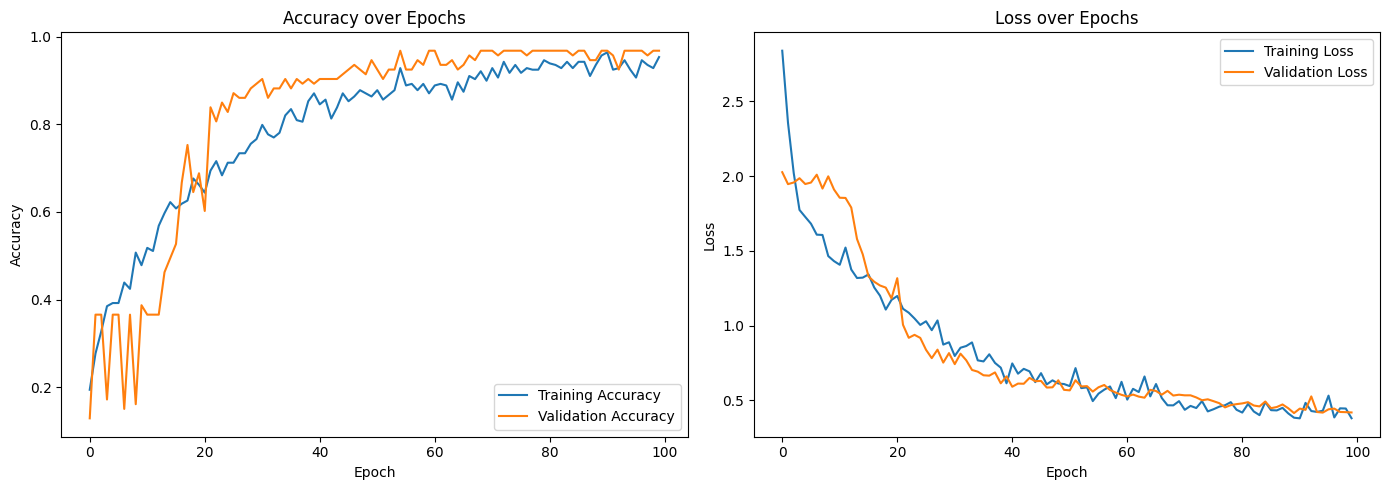

In [ ]:
plot_training_history(history)

In [ ]:
model.save('/content/drive/MyDrive/NN/model_3d_seq_conv(2+1)d.keras')

##**Prediction**

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/NN/model_3d_seq_conv(2+1)d_final_rerun.keras')

In [ ]:
def predict_asana_from_video(model, folder_path, video_name):
    frames = extract_frames_from_video(folder_path, video_name, TARGET_RESOLUTION)
    if len(frames) == 0:
        print("No frames found in the video.")
        return None
    # Add batch dimension to the frames
    frames = np.expand_dims(frames, axis=0)
    print(frames.shape)
    predictions = model.predict(frames)
    return predictions

In [ ]:
prediction = predict_asana_from_video(model, "/content/drive/MyDrive/NN/labelled dataset", "41_0127140317.mp4")
print(np.argmax(prediction, axis=1))

(1, 56, 64, 114, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
[5]


In [ ]:
# from tensorflow.keras.models import load_model
# saved_model = load_model('/content/drive/MyDrive/NN/model.keras')

# """##**Path 3: Convert New Data**"""

# def preprocess_new_data_to_training_format(new_data_folder, save_folder):
#     os.makedirs(save_folder, exist_ok=True)
#     for file in os.listdir(new_data_folder):
#         if file.endswith(".mp4"):
#             file_path = os.path.join(new_data_folder, file)
#             frames = extract_frames_from_video(file_path)
#             if len(frames) == 0:
#                 continue
#             index = get_asana_index_from_filename(file)
#             if index is None:
#                 continue
#             output_path = os.path.join(save_folder, f"{file.split('.')[0]}_asana{index}.npy")
#             np.save(output_path, {"frames": frames, "label": index})

# preprocess_new_data_to_training_format("/path/to/newdata", "/path/to/output")

#**Random Checks**

(56, 64, 114, 1)
(56, 64, 114, 1)


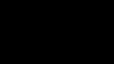

In [ ]:
# def extract(video_path, target_resolution):
#     cap = cv2.VideoCapture(video_path)
#     frames = []
#     while True:
#         ret, frame = cap.read()
#         if not ret:
#             break
#         frame = cv2.resize(frame, target_resolution)
#         frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#         frame = np.expand_dims(frame, axis=-1)  # Add channel dim → (H, W, 1)
#         frames.append(frame)
#     frames= np.array(frames)
#     # frames = crop_frames(frames)
#     frames = normalize_frames(frames)

#     cap.release()
#     return frames
# from google.colab.patches import cv2_imshow
# a=extract("/content/drive/MyDrive/NN/dataset split/only first copy dataset/120_0127143537.mp4_1.mp4", (114, 64))
# print(a.shape)
# print(np.array(a).shape)
# # for i in a:
# cv2_imshow(a[0])